In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

### Load Annotated Data

In [3]:
d_b, d_r = load_cf_data()

time: 26.2 s


In [4]:
l_b = average(d_b['aggression_score'].dropna())
l_r = average(d_r['aggression_score'].dropna())

time: 98.7 ms


In [5]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 898 ms


### Split into train/dev and test

In [6]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 83.4 ms


In [7]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 24.8 ms


In [8]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 12.9 ms


In [9]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

2

time: 46.5 ms


### NGram Regression Pipeline

In [10]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge()),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (15000,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.01, 0.1, 0.5),
}

time: 27.1 ms


### Hyper-Parameter tuning

In [11]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)


Best parameters set found:
{'vect__ngram_range': (1, 5), 'clf__alpha': 0.5, 'vect__max_features': 15000, 'vect__analyzer': 'char'} -0.261047441181


Grid scores:
-0.47177 (+/-0.00132) for {'vect__ngram_range': (1, 6), 'clf__alpha': 0.01, 'vect__max_features': 15000, 'vect__analyzer': 'char'}
-0.46982 (+/-0.00167) for {'vect__ngram_range': (1, 5), 'clf__alpha': 0.01, 'vect__max_features': 15000, 'vect__analyzer': 'char'}
-0.31008 (+/-0.00144) for {'vect__ngram_range': (1, 6), 'clf__alpha': 0.1, 'vect__max_features': 15000, 'vect__analyzer': 'char'}
-0.31273 (+/-0.00236) for {'vect__ngram_range': (1, 5), 'clf__alpha': 0.1, 'vect__max_features': 15000, 'vect__analyzer': 'char'}
-0.26335 (+/-0.00121) for {'vect__ngram_range': (1, 6), 'clf__alpha': 0.5, 'vect__max_features': 15000, 'vect__analyzer': 'char'}
-0.26105 (+/-0.00176) for {'vect__ngram_range': (1, 5), 'clf__alpha': 0.5, 'vect__max_features': 15000, 'vect__analyzer': 'char'}
time: 6min 10s


In [12]:
## Be very careful to reanscirbe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6), analyzer = 'char')),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge(alpha = 0.5)),
])

time: 5.62 ms


### Train on blocked

In [13]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 41.3 s


Eval on blocked

Explained Variance: 0.700
R^2: 0.700
Mean squared error: 0.231
Mean absolute error: 0.352
Median absolute error: 0.259
Pearson: 0.838
Spearman: 0.786


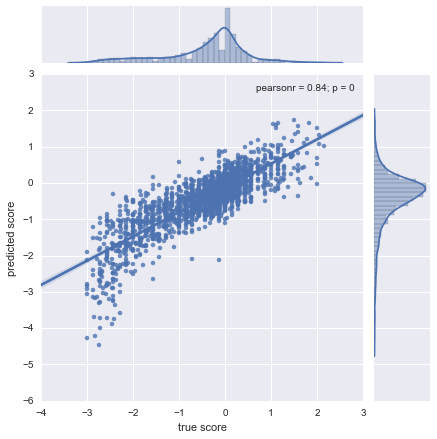

time: 9.59 s


In [14]:
print('Eval on blocked\n')
_= eval_regression(b_model, b_test, plot = True)

Eval on random

Explained Variance: 0.332
R^2: 0.288
Mean squared error: 0.121
Mean absolute error: 0.266
Median absolute error: 0.211
Pearson: 0.674
Spearman: 0.575


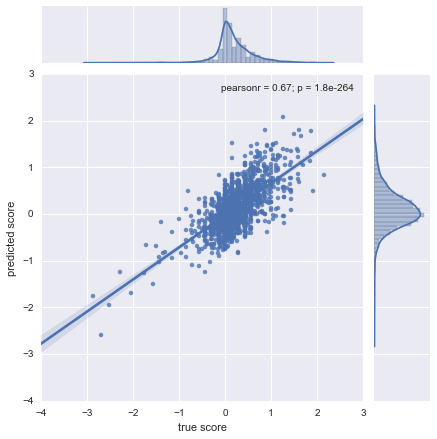

time: 6.82 s


In [15]:
print('Eval on random\n')
_= eval_regression(b_model, r_test, plot = True)

### Train on random

In [16]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 28.3 s


Eval on blocked

Explained Variance: 0.439
R^2: 0.259
Mean squared error: 0.570
Mean absolute error: 0.521
Median absolute error: 0.311
Pearson: 0.734
Spearman: 0.671


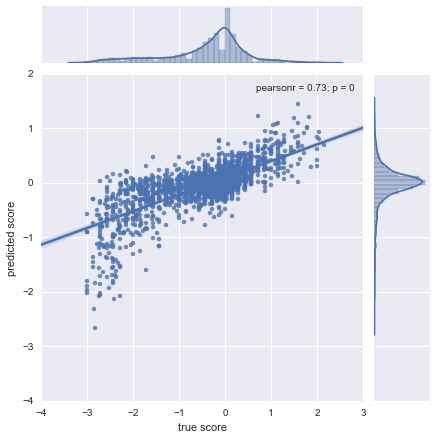

time: 6.03 s


In [17]:
print('Eval on blocked\n')
_= eval_regression(r_model, b_test, plot = True)

Eval on random

Explained Variance: 0.506
R^2: 0.505
Mean squared error: 0.084
Mean absolute error: 0.199
Median absolute error: 0.141
Pearson: 0.712
Spearman: 0.659


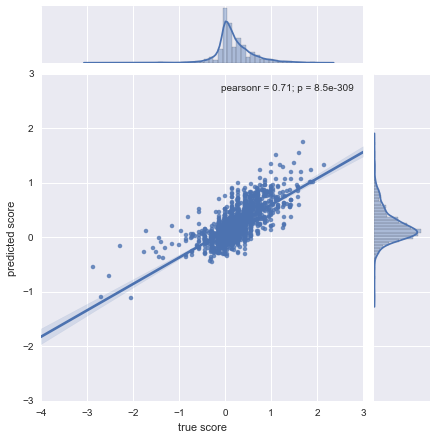

time: 4.89 s


In [18]:
print('Eval on random\n')
_= eval_regression(r_model, r_test, plot =  True)

### Train on both

In [19]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 1min 2s


Eval on blocked

Explained Variance: 0.712
R^2: 0.710
Mean squared error: 0.223
Mean absolute error: 0.341
Median absolute error: 0.242
Pearson: 0.846
Spearman: 0.800


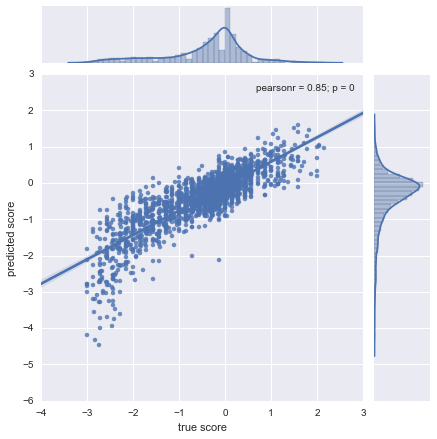

time: 6.44 s


In [20]:
print('Eval on blocked\n')
_= eval_regression(br_model, b_test, plot = True)

Eval on random

Explained Variance: 0.465
R^2: 0.459
Mean squared error: 0.092
Mean absolute error: 0.230
Median absolute error: 0.178
Pearson: 0.716
Spearman: 0.621


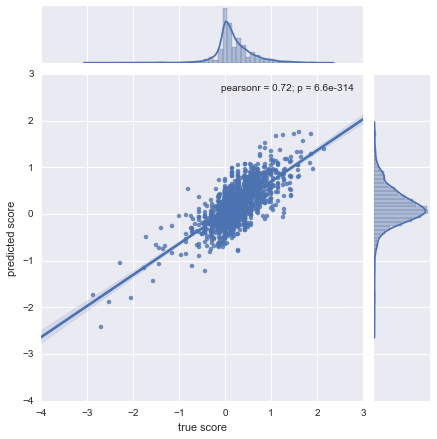

time: 5.49 s


In [21]:
print('Eval on random\n')
_= eval_regression(br_model, r_test, plot = True)

Eval on both

Explained Variance: 0.722
R^2: 0.722
Mean squared error: 0.166
Mean absolute error: 0.293
Median absolute error: 0.212
Pearson: 0.850
Spearman: 0.772


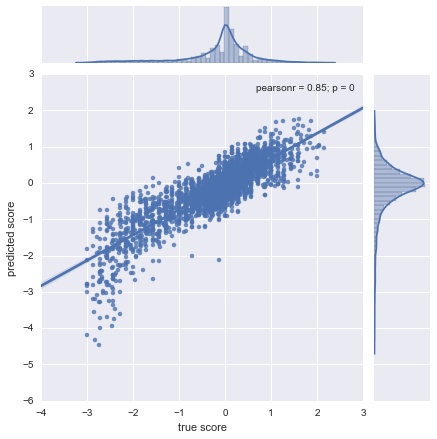

time: 11.2 s


In [22]:
print('Eval on both\n')
_= eval_regression(br_model, br_test, plot = True)

### Error Analysis

In [23]:
d_redisdual = get_reg_residuals(br_model, br_test)
print_reg_errors(d_redisdual, n=10)

COMMENT:
 Leave Me Alone You are constantly leaving me messages. Oh and one more thing, thanks for getting my Page taken off. Fag
SCORES: Actual: -2.43, Predicted: -0.44, Residual: -1.99


COMMENT:
YOURE A FRREAKING JEW, AND PLEAZE COMMIT SUICIDE.
SCORES: Actual: -2.71, Predicted: -0.74, Residual: -1.98


COMMENT:
Are you a faggot or what?
SCORES: Actual: -0.14, Predicted: -2.12, Residual: 1.98


COMMENT:
 You Rule love you Chris   
SCORES: Actual: 2.00, Predicted: 0.18, Residual: 1.82


COMMENT:
 RE: Removing my name from the KMHD article OK you little punk - you want to make it personal?  You want a war?  You got it you son of a whore!  
SCORES: Actual: -2.57, Predicted: -0.75, Residual: -1.82


COMMENT:
 Hello, you turd. Firśt, I aṃ ģoinģ ţo ţie ŷou uṗ and keeṗ ŷou çonśçiouś durinģ ţhe folloŵinģ ṗroçeśś ţhrough ţhe uśe of aṃṃonia. Nexţ, I ŵill ṃuţilaţe ŷour ģeniţalś and forçe ŷou ţo eaţ ţheṃ. Then I ŵill çuţ off biţś of ŷour śkin and ṃake a ģlove ouţ of ţhe śkin from ŷour hand. I ŵi

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked data as we add more training data.

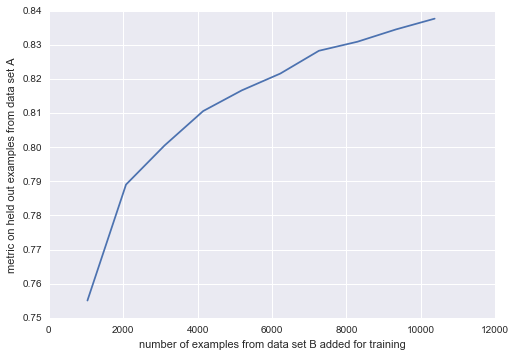

time: 5min 11s


In [24]:
def get_pearson(model, test):
    return pearsonr(test['y'], model.predict(test['x']))[0]
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_pearson, test_size = 0.5)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

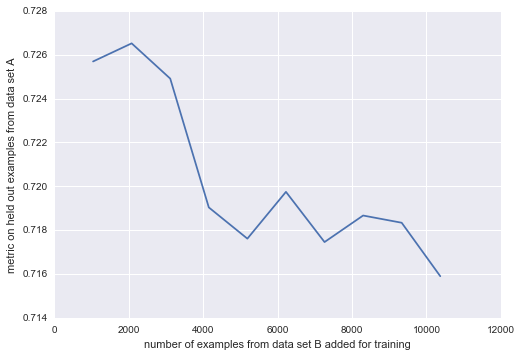

time: 25min 25s


In [25]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train, get_pearson, test_size = 0.8)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

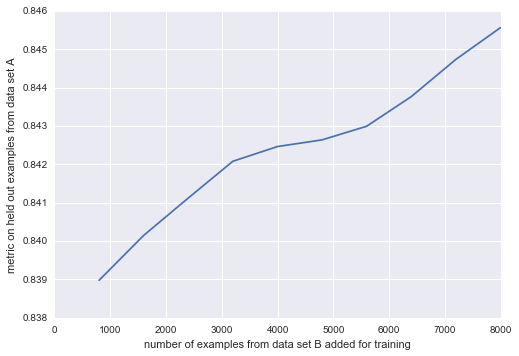

time: 23min 3s


In [26]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_pearson, test_size = 0.8)
plot_adding_other_data(ms, metrics)

# Final Model

In [27]:
br_data = pd.concat([data_r,data_b])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/aggression_regression_ngram.pkl')

['../../models/aggression_regression_ngram.pkl',
 '../../models/aggression_regression_ngram.pkl_01.npy',
 '../../models/aggression_regression_ngram.pkl_02.npy',
 '../../models/aggression_regression_ngram.pkl_03.npy',
 '../../models/aggression_regression_ngram.pkl_04.npy']

time: 3min 13s
